https://github.com/csaguiar/arrhythmia-detection/blob/master/MIT-BIH-arrhythmia-dl.ipynb

# Detecting arrythmia using Deep Leaning

## Loading modules

In [1]:
!pip install wfdb wget

In [2]:
import pandas as pd
import numpy as np
import wfdb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Dropout, TimeDistributed
from keras.optimizers import Adam

In [4]:
import matplotlib.pyplot as plt

## Download Dataset

In [5]:
import wget
import zipfile

database_filename = "mit-bih-arrhythmia-database-1.0.0.zip"
database_path = Path(database_filename)

if not database_path.exists():
    url = f'https://storage.googleapis.com/mitdb-1.0.0.physionet.org/{database_filename}'
    wget.download(url)
    with zipfile.ZipFile(database_filename, 'r') as zip_ref:
        zip_ref.extractall(".")

## Loading data

Loading list of records available, from dataset available [here](https://physionet.org/content/mitdb/1.0.0/)

In [6]:
records = np.loadtxt("mit-bih-arrhythmia-database-1.0.0/RECORDS", dtype=int)

Defining invalid beats as well as abnormal beats, according to [Physiobank](https://archive.physionet.org/physiobank/annotations.shtml)

In [7]:
invalid_beat = [
    "[", "!", "]", "x", "(", ")", "p", "t", 
    "u", "`", "'", "^", "|", "~", "+", "s", 
    "T", "*", "D", "=", '"', "@"
]

abnormal_beats = [
    "L", "R", "B", "A", "a", "J", "S", "V", 
    "r", "F", "e", "j", "n", "E", "/", "f", "Q", "?"
]

## Processing dataset

This function classify a beat according to its symbol and the list provided above.

In [8]:
def classify_beat(symbol):
    if symbol in abnormal_beats:
        return 1
    elif symbol == "N" or symbol == ".":
        return 0    

Given a signal, the beat location, and the window to be used as a sequence, this function gets the sequence. It will return an empty array in case of an invalid beat or empty sequence.

In [9]:
def get_sequence(signal, beat_loc, window_sec, fs):
    window_one_side = window_sec * fs
    beat_start = beat_loc - window_one_side
    beat_end = beat_loc + window_one_side
    if beat_end < signal.shape[0]:
        sequence = signal[beat_start:beat_end, 0]
        return sequence.reshape(1, -1, 1)
    else:
        return np.array([])

The code below will build a list of labels and sequences as well as map the sequences for each patient. The percentage calculated represents the ratio of abnormal beats in each patient data.

In [10]:
all_sequences = []
all_labels = []
window_sec = 3
subject_map = []
for subject in records:
    record = wfdb.rdrecord(f'mit-bih-arrhythmia-database-1.0.0/{subject}')
    annotation = wfdb.rdann(f'mit-bih-arrhythmia-database-1.0.0/{subject}', 'atr')
    atr_symbol = annotation.symbol
    atr_sample = annotation.sample
    fs = record.fs
    scaler = StandardScaler()
    signal = scaler.fit_transform(record.p_signal)
    subject_labels = []
    for i, i_sample in enumerate(atr_sample):
        label = classify_beat(atr_symbol[i])
        sequence = get_sequence(signal, i_sample, window_sec, fs)
        if label is not None and sequence.size > 0:
            all_sequences.append(sequence)
            subject_labels.append(label)

    normal_percentage = sum(subject_labels) / len(subject_labels)
    subject_map.append({
        "subject": subject,
        "percentage": normal_percentage,
        "num_seq": len(subject_labels),
        "start": len(all_labels),
        "end": len(all_labels)+len(subject_labels)
    })
    all_labels.extend(subject_labels)

In [11]:
pd.Series(all_labels).describe()

count    109132.000000
mean          0.314637
std           0.464373
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
dtype: float64

In [12]:
all_sequences[0:3]

[array([[[-0.17443635],
         [-0.14855637],
         [-0.12267639],
         ...,
         [-0.27795626],
         [-0.22619631],
         [-0.17443635]]]), array([[[-0.43323614],
         [-0.45911611],
         [-0.53675605],
         ...,
         [-0.17443635],
         [-0.14855637],
         [-0.12267639]]]), array([[[-0.48499609],
         [-0.53675605],
         [-0.61439599],
         ...,
         [-0.12267639],
         [-0.12267639],
         [-0.17443635]]])]

In [13]:
for i in [0,1,2]:
  print(all_sequences[i].shape)

(1, 2160, 1)
(1, 2160, 1)
(1, 2160, 1)


Creating bins to be used to stratify the train and validation split. 

In [14]:
subject_map = pd.DataFrame(subject_map)

In [15]:
subject_map.head()

,subject,percentage,num_seq,start,end
0,100,0.015018,2264,0,2264
1,101,0.002691,1858,2264,4122
2,102,0.954566,2179,4122,6301
3,103,0.000962,2078,6301,8379
4,104,0.926610,2221,8379,10600


The code presented will create class in each patient is segmented.

In [16]:
bins = [0, 0.2, 0.6, 1.0]
subject_map["bin"] = pd.cut(subject_map['percentage'], bins=bins, labels=False, include_lowest=True)
subject_map.head()

,subject,percentage,num_seq,start,end,bin
0,100,0.015018,2264,0,2264,0
1,101,0.002691,1858,2264,4122,0
2,102,0.954566,2179,4122,6301,2
3,103,0.000962,2078,6301,8379,0
4,104,0.926610,2221,8379,10600,2


In [17]:
subject_map.describe()

,subject,percentage,num_seq,start,end,bin
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,166.229167,0.324887,2273.583333,51641.520833,53915.104167,0.666667
std,53.622494,0.395465,450.785784,31914.617065,32044.416846,0.883256
min,100.000000,0.000000,1512.000000,0.000000,2264.000000,0.000000
25%,112.750000,0.017210,1954.250000,25611.250000,27585.000000,0.000000
50%,200.500000,0.157546,2211.500000,48781.500000,51056.500000,0.000000
75%,215.500000,0.698289,2571.250000,79289.250000,82354.500000,2.000000
max,234.000000,1.000000,3353.000000,106387.000000,109132.000000,2.000000


Now, the dataset is split into train and validation, stratifying by the bin defined above.

In [18]:
train, validation = train_test_split(subject_map, test_size=0.25, stratify=subject_map["bin"], random_state=42)

This function build a dataset based on the map for each split.

In [19]:
def build_dataset(df, all_sequences, all_labels):
    sequences = []
    labels = []
    for i, row in df.iterrows():
        start = int(row["start"])
        end = int(row["end"])
        sequences.extend(all_sequences[start:end])
        labels.extend(all_labels[start:end])
        
    return np.vstack(sequences), np.vstack(labels)

In [20]:
X_train, y_train = build_dataset(train, all_sequences, all_labels)
X_val, y_val = build_dataset(validation, all_sequences, all_labels)

In [21]:
X_train.shape, y_train.shape

((82873, 2160, 1), (82873, 1))

In [22]:
X_train[:, :, 0].shape   

(82873, 2160)

## Training the model

For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.

For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.

‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty

‘liblinear’ and ‘saga’ also handle L1 penalty

‘saga’ also supports ‘elasticnet’ penalty

‘liblinear’ does not support setting penalty='none'

In [32]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, accuracy_score  # log_loss
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score

def print_stats(preds, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

def gs(X, y, m, param, scoring, cv, n_jobs):
    GridSearch = GridSearchCV(m, param, scoring=scoring, cv=cv, n_jobs=n_jobs)
    GridSearch.fit(X=X, y=y)
    model = GridSearch.best_estimator_
    print('best_score_:', GridSearch.best_score_, GridSearch.best_params_)
    return model



In [42]:
from sklearn.ensemble import RandomForestClassifier 
def classify_RF(y, X, seed=2020, scoring='roc_auc', cv=5, n_jobs=4):
    cols = X.columns
    param = {
        'max_features': ['sqrt', 'log2'],  # 1.0/3 
             'max_depth': range(10, 14, 2)
             # 'criterion' :['gini', 'entropy']
             }
    m = RandomForestClassifier(
        n_estimators=10, random_state=seed, min_samples_split=20, class_weight="balanced")
    model = gs(X, y, m, param, scoring=scoring, cv=cv, n_jobs=n_jobs)
    coef = pd.DataFrame(list(zip(cols, np.round(
        model.feature_importances_, 2))), columns=['Variable', 'coef_'])
    coef['imp'] = coef['coef_'].abs()
    return model, coef.sort_values('imp', ascending=False)

m_, c_ = classify_RF(y_train.ravel(), pd.DataFrame(X_train[:, :, 0]), seed=2020, scoring='accuracy', cv=4, n_jobs=2)
# , c_ 
ytest_pred = m_.predict(X_val[:, :, 0])
print_stats(ytest_pred, y_val)    
m_
# best_score_: 0.9102368067602846 {'max_depth': 8, 'max_features': 'auto'}
# Accuracy = 0.7921855363875243
# Precision = 0.6713230200877396
# Recall = 0.6902077151335312

# best_score_: 0.9108159200629632 {'max_depth': 10}
# Accuracy = 0.8210899120301611
# Precision = 0.7383906869643085
# Recall = 0.6851038575667656

best_score_: 0.9108159200629632 {'max_depth': 10, 'max_features': 'sqrt'}
Accuracy = 0.8210899120301611
Precision = 0.7383906869643085
Recall = 0.6851038575667656


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=2020,
                       verbose=0, warm_start=False)

In [40]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           AuthenticAMD
CPU family:          23
Model:               49
Model name:          AMD EPYC 7B12
Stepping:            0
CPU MHz:             2249.998
BogoMIPS:            4499.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            512K
L3 cache:            16384K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid extd_apicid tsc_known_freq pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm cmp_legacy cr8_legacy abm sse4a 

In [ ]:
# LogisticRegression
# best_score_: 0.7592099133190755 {'C': 0.1} solver='sag', tol=0.01,
# Accuracy = 0.7579115731749114
# Precision = 0.6668280090351726
# Recall = 0.49056379821958457

### CNN model

In [25]:
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense, Dropout
from keras.optimizers import Adam

sequence_size = X_train.shape[1]
n_features = 1

cnn_model = Sequential([
    Conv1D(
        filters=8,
        kernel_size=4,
        strides=1,
        input_shape=(sequence_size, n_features),
        padding="same",
        activation="relu"
    ),
    Flatten(),
    Dropout(0.5),
    Dense(
        1,
        activation="sigmoid",
        name="output",
    )
])

optimizer = Adam(lr=0.001)
# Compiling the model
cnn_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2160, 8)           40        
_________________________________________________________________
flatten (Flatten)            (None, 17280)             0         
_________________________________________________________________
dropout (Dropout)            (None, 17280)             0         
_________________________________________________________________
output (Dense)               (None, 1)                 17281     
Total params: 17,321
Trainable params: 17,321
Non-trainable params: 0
_________________________________________________________________


In [29]:
hist_cnn = cnn_model.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=5,
    validation_data=(X_val, y_val)
)

Epoch 1/5
648/648 [==============================] - 47s 72ms/step - loss: 0.1290 - accuracy: 0.9590 - val_loss: 0.5983 - val_accuracy: 0.8356
Epoch 2/5
648/648 [==============================] - 47s 72ms/step - loss: 0.1274 - accuracy: 0.9599 - val_loss: 0.6151 - val_accuracy: 0.8227
Epoch 3/5
648/648 [==============================] - 47s 73ms/step - loss: 0.1251 - accuracy: 0.9602 - val_loss: 0.6043 - val_accuracy: 0.8318
Epoch 4/5
648/648 [==============================] - 47s 72ms/step - loss: 0.1218 - accuracy: 0.9623 - val_loss: 0.6366 - val_accuracy: 0.8265
Epoch 5/5
648/648 [==============================] - 47s 72ms/step - loss: 0.1201 - accuracy: 0.9619 - val_loss: 0.6663 - val_accuracy: 0.8236


In [30]:
cnn_model.evaluate(X_val, y_val)

821/821 [==============================] - 6s 8ms/step - loss: 0.6663 - accuracy: 0.8236


[0.6663442254066467, 0.8236033320426941]

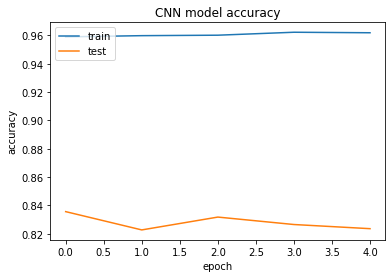

In [31]:
# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

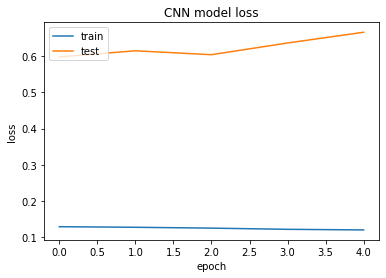

In [32]:
# summarize history for loss
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### CNN with LSTM model

In [33]:
sequence_size = X_train.shape[1]
n_features = 1 
n_subsequences = 4
subsequence_size = int(sequence_size / n_subsequences)

# Reshaping to be (samples, subsequences, sequence, feature)
X_train = X_train.reshape(-1, n_subsequences, subsequence_size, n_features)
X_val = X_val.reshape(-1, n_subsequences, subsequence_size, n_features)

In [34]:
cnn_lstm_model = Sequential([
    TimeDistributed(
        Conv1D(
            filters=8,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="relu"
        ), 
        input_shape=(n_subsequences, subsequence_size, n_features)
    ),
    TimeDistributed(Flatten()),
    LSTM(units=4),
    Dense(
        1,
        activation="sigmoid",
        name="output",
    )
])

optimizer = Adam(lr=0.001)
# Compiling the model
cnn_lstm_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
cnn_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 4, 540, 8)         40        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 4320)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 4)                 69200     
_________________________________________________________________
output (Dense)               (None, 1)                 5         
Total params: 69,245
Trainable params: 69,245
Non-trainable params: 0
_________________________________________________________________


In [35]:
train_params = {
    "batch_size": 128,
    "epochs": 5,
    "verbose": 1,
    "validation_data": (X_val, y_val),
}

history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train, **train_params)

Epoch 1/5
648/648 [==============================] - 46s 67ms/step - loss: 0.3888 - accuracy: 0.8313 - val_loss: 0.6344 - val_accuracy: 0.7487
Epoch 2/5
648/648 [==============================] - 43s 67ms/step - loss: 0.1443 - accuracy: 0.9531 - val_loss: 0.6349 - val_accuracy: 0.7619
Epoch 3/5
648/648 [==============================] - 46s 70ms/step - loss: 0.1162 - accuracy: 0.9619 - val_loss: 0.5955 - val_accuracy: 0.7852
Epoch 4/5
648/648 [==============================] - 45s 69ms/step - loss: 0.1013 - accuracy: 0.9670 - val_loss: 0.6491 - val_accuracy: 0.7797
Epoch 5/5
648/648 [==============================] - 45s 69ms/step - loss: 0.0845 - accuracy: 0.9720 - val_loss: 0.6175 - val_accuracy: 0.7812


In [36]:
cnn_lstm_model.evaluate(X_val, y_val)

821/821 [==============================] - 8s 9ms/step - loss: 0.6175 - accuracy: 0.7812


[0.617514431476593, 0.7811797857284546]

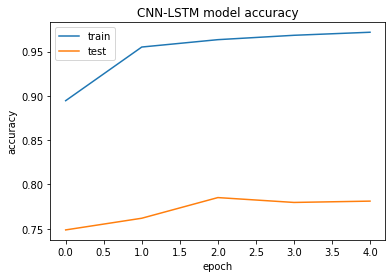

In [37]:
# summarize history for accuracy
plt.plot(history_cnn_lstm.history['accuracy'])
plt.plot(history_cnn_lstm.history['val_accuracy'])
plt.title('CNN-LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

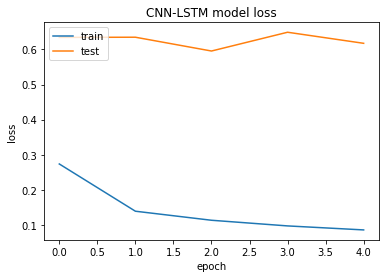

In [38]:
# summarize history for loss
plt.plot(history_cnn_lstm.history['loss'])
plt.plot(history_cnn_lstm.history['val_loss'])
plt.title('CNN-LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()